<a href="https://colab.research.google.com/github/YogiJungHoonYeon/Artificial-Intelligence-Lang/blob/main/Tacotron2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#!pip

In [ ]:
!pip install ffmpeg
!pip install pydub
!pip install jamo

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=ddb051b9470f71804da12404f60c8123a06a1db1ef0f0bc9d0c85e292fe22d7b
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


#modules

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import re
import pandas as pd
from jamo import h2j, j2hcj
from scipy.io import wavfile #입력
import IPython.display as ipd #출력
from pydub import AudioSegment #m4a -> wave file
import librosa
import csv
import unicodedata




#Data_Preprocessing_New

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/wav_datasets/'
csv_path = 'Data3.csv'
def make_xlsx(dataset_path,csv_path):
  file_name_list = []
  for file_name in os.listdir(dataset_path):
    file_name = file_name.replace('.wav','')
    file_name_edit = unicodedata.normalize('NFC', file_name)
    file_name_list.append(file_name_edit)
  csv_data_frame_temp = pd.DataFrame(file_name_list,columns=['sentence'])
  csv_data_frame_temp.to_csv(csv_path,index=False,encoding='utf-8-sig')






make_xlsx(dataset_path,csv_path)


#mkdir

In [ ]:
os.mkdir('m4a_folder')
os.mkdir('wav_folder')

#word_embedding

In [ ]:
class ko_embedding():
  def word_preprocessing(self,sentences):

    stop_words = ['/', '"', "'", '`', '@', '#', '$', '%', '^', '&', '*', '()', '(', ')', '_', '-', '+', '=', '<', '>']
    vocab = []
    filter = re.compile('[a-zA-Z0-9]')

    for index, sentence in enumerate(sentences):
      if index == 0:
        print('첫번 째 sentence:{}'.format(sentence))
      joined_sentence = '|'.join(sentence[0])


      jamo_str = j2hcj(h2j(joined_sentence))

      for stop_word in stop_words:
        jamo_str = jamo_str.replace(stop_word,'')

      jamo_str = list(jamo_str)

      filter_list = filter.findall(sentence[0])
      for filtered_word in filter_list:
        jamo_str.remove(filtered_word)



      vocab.append(jamo_str) #len(vocab) = number of words => [[문장1], [문장2], [문장3] ...]

    return vocab




  def dict_make(self):
    initial = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ' ,'ㅊ','ㅋ', 'ㅌ','ㅍ','ㅎ','ㄲ','ㅃ','ㅉ','ㅆ','ㄸ'] #19
    neutral = ['ㅏ','ㅐ','ㅑ','ㅒ','ㅓ','ㅔ','ㅕ','ㅖ','ㅗ','ㅘ','ㅙ','ㅚ','ㅛ','ㅜ','ㅝ','ㅞ','ㅟ','ㅠ','ㅡ','ㅢ','ㅣ'] #21
    final = ['ㄱ','ㄲ','ㄳ','ㄴ','ㄵ','ㄶ','ㄷ','ㄹ','ㄺ','ㄻ','ㄼ','ㄽ','ㄾ','ㄿ','ㅀ','ㅁ','ㅂ','ㅄ','ㅅ','ㅆ','ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ',' '] #28

    initial_dict = {}
    neutral_dict = {}
    final_dict = {}
    added_dict = {}
    for index, value in enumerate(initial):
      initial_dict[value] = index
    for index, value in enumerate(neutral):
      neutral_dict[value] = index + len(initial)
    for index, value in enumerate(final):
      final_dict[value] = index + len(initial) + len(neutral)

    added_dict['?'] = 71
    added_dict['!'] = 72
    added_dict['~'] = 73
    added_dict['..'] = 74
    added_dict['.'] = 75
    added_dict[','] = 76
    return initial_dict, neutral_dict, final_dict, added_dict

  #[['ㅇ', 'ㅏ', 'ㄴ', '|', 'ㄴ', 'ㅕ', 'ㅇ', '|', ' ', '|', 'ㅇ', 'ㅣ', '|'
  #, 'ㄹ', 'ㅏ', '|', 'ㄱ', 'ㅗ', '|', ' ', '|', 'ㅁ', 'ㅏ', 'ㄹ', '|', 'ㅎ', 'ㅐ', '|', 'ㄷ', 'ㅗ', '|', ' ', '|'
  #, 'ㄷ', 'ㅙ', '|', 'ㅇ', 'ㅛ', '|', '?', '|', '!', '|', '~', '|', '!', '|', ' ', '|', '|', '|', '|', '|', '|']]
  def word_embedding(self,vocab):
    initial_dict,neutral_dict,final_dict,added_dict = self.dict_make()
    encoded_vocab = []

    for sentence in vocab:
      i = 1
      sentence_vocab = []
      for character in sentence:

        if character == '|' :
          i = 1
          continue;
        if character == ' ':
          i = 1
          sentence_vocab.append(final_dict[character])
          continue;
        if character == '?' or character == '!' or character == '..' or character== '.' or character=='~' or character==',':
          sentence_vocab.append(added_dict[character])
          continue;

        if i == 1:
          sentence_vocab.append(initial_dict[character])
        if i == 2:
          sentence_vocab.append(neutral_dict[character])
        if i == 3:
          sentence_vocab.append(final_dict[character])
        i  = i + 1
        if i % 4 == 0:
          i = 1

      encoded_vocab.append(sentence_vocab)

    return encoded_vocab



  def final_word_embedding(self,encoded_vocab,embedding_dim):

    length_list = []
    vocab_list = []
    for encoded_sentence in encoded_vocab:
      encoded_sentence.insert(0, 68) #<sos>
      encoded_sentence.append(69) #<eos>
      length_list.append(len(encoded_sentence))
    max_length = max(length_list)

    for encoded_sentence in encoded_vocab:
      for _ in range(max_length - len(encoded_sentence)):
        encoded_sentence.append(70) #<pad>
      vocab_list.append(encoded_sentence)

    word_vec = np.zeros(shape=(len(encoded_vocab), max_length, embedding_dim))

    for k, encoded_sentence in enumerate(vocab_list):

      for m, i in enumerate(encoded_sentence):

        word_vec[k,m,i] = 1

    return word_vec





  def call(self,sentence_list):
    vocab = self.word_preprocessing(sentence_list)

    vocab = self.word_embedding(vocab)
    word_vec = self.final_word_embedding(vocab,128)
    word_vec = np.asarray(word_vec)
    return word_vec





#mel-spectrogram

In [ ]:
def m4a_to_wav(m4a_folder_name, wav_folder_name):
  dir_path = os.getcwd()

  m4a_folder_path = os.path.join(dir_path, m4a_folder_name)
  wav_folder_path = os.path.join(dir_path, wav_folder_name)

  for file_name in os.listdir(m4a_folder_path):
    file_path = os.path.join(m4a_folder_path, file_name)
    if os.path.isdir(file_path) != True:
      audio_m4a = AudioSegment.from_file(file_path, format='m4a')

      wav_file_path = os.path.join(wav_folder_name, file_name)
      audio_m4a.export(wav_file_path, format='wav')
    else:
      pass;


def Mel_spectrogram(wav_folder_name, frame_length, frame_stride, n_mels):
  mel_spectrogram_list = []
  dir_name = os.getcwd()
  wav_folder_path = os.path.join(dir_name, wav_folder_name)
  for index, file_name in enumerate(os.listdir(wav_folder_path)):
    if index ==0:
      print('첫 번째 mel_spectrogram:{}'.format(file_name))
    wav_file_path = os.path.join(wav_folder_path, file_name)
    if os.path.isdir(wav_file_path) != True:
      #print('wav_file_path in Mel_spctrogram def:{}'.format(wav_file_path))
      data, sampling_rate = librosa.load(wav_file_path)
      n_fft = int(round(sampling_rate * frame_length))
      stride = int(round(sampling_rate * frame_stride))
    else:
      pass;

    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_fft=n_fft,
                                                     hop_length = stride) #n_mels = n_channels
    mel_spectrogram_list.append(mel_spectrogram)

  return mel_spectrogram_list

def mel_spectrogram_list_pad(Mel_spectrogram_list, embedding_dim):
  length_list = []
  for mel_spectrogram in Mel_spectrogram_list:
    length_list.append(mel_spectrogram.shape[1])
  max_length = max(length_list)
  mel_spectrogram_list = []
  for mel_spectrogram in Mel_spectrogram_list:
    if max_length > embedding_dim:

      mel_spectrogram = np.pad(mel_spectrogram, pad_width = ((0,0), (0,max_length - mel_spectrogram.shape[1])),
            mode = 'constant', constant_values=0)
      mel_spectrogram_list.append(mel_spectrogram)
    else:
      mel_spectrogram = np.pad(mel_spectrogram, pad_width = ((0,0), (0,embedding_dim - mel_spectrogram.shape[1])),
            mode = 'constant', constant_values=0)
      mel_spectrogram_list.append(mel_spectrogram)

  return mel_spectrogram_list

def mel_spectrogram_to_numpy(mel_spectrogram_list):
  n_of_mel_spectrogram = len(mel_spectrogram_list)
  mel_spectrogram_numpy = np.zeros((n_of_mel_spectrogram, mel_spectrogram_list[0].shape[0], mel_spectrogram_list[0].shape[1]))
  for i, mel_spectrogram in enumerate(mel_spectrogram_list):
    mel_spectrogram_numpy[i][:][:] = mel_spectrogram

  return mel_spectrogram_numpy


In [ ]:
class audio_data_preprocessing():
  def call(m4a_folder_name, wav_folder_name, frame_length, frame_stride, n_mels, embedding_dim):
    #m4a_to_wav(m4a_folder_name, wav_folder_name)
    mel_spectrogram_list = Mel_spectrogram(wav_folder_name, frame_length, frame_stride, n_mels)
    mel_spectrogram_list = mel_spectrogram_list_pad(mel_spectrogram_list, embedding_dim)
    mel_spectrogram = mel_spectrogram_to_numpy(mel_spectrogram_list)
    return mel_spectrogram

In [ ]:
class audio_data_preprocessing_transformed():
  def m4a_to_wav(self, m4a_folder_name, wav_folder_name):
    dir_path = os.getcwd()
    m4a_folder_path = os.path.join(dir_path, m4a_folder_name)
    wav_folder_path = os.path.join(dir_path, wav_folder_name)

    for file_name in os.listdir(m4a_folder_path):
      file_path = os.path.join(m4a_folder_path, file_name)
      if os.path.isdir(file_path) != True:
        audio_m4a = AudioSegment.from_file(file_path, format='m4a')

        wav_file_path = os.path.join(wav_folder_name, file_name)
        audio_m4a.export(wav_file_path, format='wav')
      else:
        pass;
  def Mel_spectrogram(self,wav_folder_name, frame_length, frame_stride, n_mels):
    mel_spectrogram_list = []
    dir_name = os.getcwd()
    wav_folder_path = os.path.join(dir_name, wav_folder_name)
    for file_name in os.listdir(wav_folder_path):
      wav_file_path = os.path.join(wav_folder_path, file_name)
      if os.path.isdir(wav_file_path) != True:
        data, sampling_rate = librosa.load(wav_file_path)
        n_fft = int(round(sampling_rate * frame_length))
        stride = int(round(sampling_rate * frame_stride))
      else:
        pass;

      mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_fft=n_fft,
                                                      hop_length = stride,n_mels = n_mels ) #n_mels = n_channels
      mel_spectrogram_list.append(mel_spectrogram)

    return mel_spectrogram_list
  def mel_spectrogram_list_pad(self,Mel_spectrogram_list, embedding_dim):
    length_list = []
    for mel_spectrogram in Mel_spectrogram_list:
      length_list.append(mel_spectrogram.shape[1])
    max_length = max(length_list)
    mel_spectrogram_list = []
    for mel_spectrogram in Mel_spectrogram_list:
      if max_length > embedding_dim:

        mel_spectrogram = np.pad(mel_spectrogram, pad_width = ((0,0), (0,max_length - mel_spectrogram.shape[1])),
              mode = 'constant', constant_values=0)
        mel_spectrogram_list.append(mel_spectrogram)
      else:
        mel_spectrogram = np.pad(mel_spectrogram, pad_width = ((0,0), (0,embedding_dim - mel_spectrogram.shape[1])),
              mode = 'constant', constant_values=0)
        mel_spectrogram_list.append(mel_spectrogram)

    return mel_spectrogram_list
  def mel_spectrogram_to_numpy(self,mel_spectrogram_list):
    n_of_mel_spectrogram = len(mel_spectrogram_list)
    mel_spectrogram_numpy = np.zeros((n_of_mel_spectrogram, mel_spectrogram_list[0].shape[0], mel_spectrogram_list[0].shape[1]))
    for i, mel_spectrogram in enumerate(mel_spectrogram_list):
      mel_spectrogram_numpy[i][:][:] = mel_spectrogram

    return mel_spectrogram_numpy

  def call(self,m4a_folder_name, wav_folder_name, frame_length, frame_stride, n_mels, embedding_dim):

    self.m4a_to_wav(m4a_folder_name, wav_folder_name)
    mel_spectrogram_list = self.Mel_spectrogram(wav_folder_name, frame_length, frame_stride, n_mels)
    mel_spectrogram_list = self.mel_spectrogram_list_pad(mel_spectrogram_list, embedding_dim)
    mel_spectrogram = self.mel_spectrogram_to_numpy(mel_spectrogram_list)
    return mel_spectrogram



#Preprocessing

In [ ]:
class train_data_generation():
  def call(m4a_folder_name, wav_folder_name, frame_length, frame_stride, n_mels,csv_file_name,embedding_dim):
    ko = ko_embedding()
    sentence_list = []
    df = pd.read_csv(csv_file_name)
    for i in range(df.size):
      sentence_list.append([df['sentence'][i]])

    word_vec = ko.call(sentence_list)
    word_vec = tf.cast(word_vec, tf.dtypes.float32)
    mel_spectrogram = audio_data_preprocessing.call(m4a_folder_name, wav_folder_name, frame_length, frame_stride, n_mels,
                                                    embedding_dim)

    return word_vec, mel_spectrogram


word_vec, mel_spectrogram = train_data_generation.call('m4a_folder','/content/drive/MyDrive/wav_datasets/', 0.025, 0.010
                                                       , 80, 'Data3.csv',454 )

첫번 째 sentence:['추웠던겨울은가고']
첫 번째 mel_spectrogram:추웠던겨울은가고.wav


In [ ]:
print('word_vec.shape:{}, mel_spectrogram.shape:{}'.format(word_vec.shape, mel_spectrogram.shape))

word_vec.shape:(103, 94, 128), mel_spectrogram.shape:(103, 128, 846)


# Model_modules

In [ ]:
from tensorflow.keras.activations import tanh, softmax
from tensorflow.random import uniform
from tensorflow.keras.layers import Conv1D, BatchNormalization, Bidirectional, Dense, LSTM
from tensorflow.keras.models import Model,model_from_json
from tensorflow.keras.losses import MeanSquaredError, Loss
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# Model

In [ ]:
print('mel_spectrogram:{}, word_vec:{}'.format(mel_spectrogram.shape, word_vec.shape))

mel_spectrogram:(103, 128, 846), word_vec:(103, 94, 128)


In [ ]:
class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1d_1 = Conv1D(filters=16, kernel_size=5, padding = 'same')
        self.conv1d_2 = Conv1D(filters = 64, kernel_size=5, padding= 'same')
        self.conv1d_3 = Conv1D(filters=32, kernel_size=5,padding='same')

        self.batch_norm_1 = BatchNormalization()
        self.batch_norm_2 = BatchNormalization()
        self.batch_norm_3 = BatchNormalization()
        self.bi_lstm = Bidirectional(LSTM(units=64, return_sequences=True))
        #mel_spectrogram C//2 = E_L



    def call(self, word_vec):

        first = self.conv1d_1(word_vec)
        first_batch = self.batch_norm_1(first)

        second = self.conv1d_2(first_batch)
        second_batch = self.batch_norm_2(second)

        third = self.conv1d_3(second_batch)
        third_batch = self.batch_norm_3(third)

        hidden = self.bi_lstm(third)
        return hidden


class Attention(Model):
  def __init__(self, attention_dim):
    super(Attention, self).__init__()


    self.linear_after_lstm = Dense(units = attention_dim)
    self.linear_hidden = Dense(units = attention_dim)
    self.linear_filter = Dense(units = attention_dim)
    #self.linear_location_sensitive = Dense(units = attention_dim, activation = 'relu')
    #self.conv1D = Conv1D(filters = attention_dim, kernel_size = 1)
    self.v = Dense(units = 1)





  def call(self, time, hidden, after_lstm, attention_score):
    if time==0:


      value_e = self.v(tanh(self.linear_hidden(tf.transpose(hidden, perm=[0,2,1]))))

      attention_score = tf.transpose(softmax(value_e), perm=[0,2,1])

      return attention_score

    else:

      #after_filtered = self.conv1D(attention_score) #(B,T,C) 1,1,atten_dim

      value_e = self.v(tanh(self.linear_filter(tf.transpose(attention_score,perm=[0,2,1]))
      + self.linear_hidden(tf.transpose(hidden, perm=[0,2,1]))
       + self.linear_filter(tf.transpose(attention_score,perm=[0,2,1]))))
      attention_score_result = tf.transpose(softmax(value_e), perm=[0,2,1])

      return attention_score_result




class Decoder(Model):
  def __init__(self):
    super(Decoder,self).__init__()
    self.prenet_1 = Dense(units = 64)
    self.prenet_2 = Dense(units = 128, activation = 'relu')
    #D_L = mel_shape C
    self.LSTM_1 = LSTM(units = 64 , return_sequences=True)
    self.LSTM_2 = LSTM(units = 128, activation = 'tanh', return_sequences=True)
  def prenet(self, previous_decoder):
    output_1 = self.prenet_1(previous_decoder)
    output_2 = self.prenet_2(output_1)
    return output_2



  def call(self,previous_decoder, hidden,attention_score):
    context_vector = tf.multiply(attention_score, hidden)

    after_prenet = self.prenet(previous_decoder)

    lstm_input_1 = tf.concat([context_vector, tf.transpose(after_prenet, perm=[0,2,1])],axis = -1)

    after_lstm_1 = self.LSTM_1(lstm_input_1)


    lstm_input_2 = tf.concat([context_vector, after_lstm_1],axis = -1)
    after_lstm_2 = self.LSTM_2(lstm_input_2)

    return after_lstm_2


class Tacotron2(Model):
  def __init__(self, attention_dim, mel_spectrogram_shape, batch_size,training = True):
    super(Tacotron2, self).__init__()


    self.encoder = Encoder()
    self.attention = Attention(attention_dim)
    self.decoder = Decoder()

    self.stop_dense = Dense(units = 1, activation = 'sigmoid')
    self.mel_spectrogram_dense = Dense(units = 1)

    self.conv1D_1 = Conv1D(filters = 16, kernel_size = 31,  padding ='same')
    self.conv1D_2 = Conv1D(filters = 32, kernel_size = 31,  padding ='same')
    self.conv1D_3 = Conv1D(filters = 64, kernel_size = 31,  padding ='same')
    self.conv1D_4 = Conv1D(filters = 128, kernel_size = 31,  padding ='same')



    self.mel_shape = mel_spectrogram_shape
    self.training = training
    self.batch_size = batch_size

  def post_net(self, predicted_mel_spectrogram):
    conv_1 = self.conv1D_1(predicted_mel_spectrogram)
    conv_2 = self.conv1D_2(conv_1)
    conv_3 = self.conv1D_3(conv_2)
    conv_4 = self.conv1D_4(conv_3)
    return conv_4

  @tf.function
  def stop_cal(self,training , stop_threshold , stop_index, time,stop_prob):
    if tf.equal(training, False) and tf.greater(stop_prob , stop_threshold) and tf.equal(stop_index, 0):
      stop_index = time
    return stop_index




  def call(self, inputs):
    word_vec = inputs #B,T,C

    hidden = self.encoder.call(word_vec)


    attention_score_list = 0
    after_lstm_list = 0
    previous_decoder_list = []

    stop_threshold = tf.constant(0.5, dtype = tf.float32)


    stop_list = []
    stop_index = 0

    time_step = 0
    load_value = self.mel_shape[1] // 100


    mel_init = np.random.normal(size=[self.batch_size, self.mel_shape[2], 1])




    for time in range(self.mel_shape[1]):

      if time==0:

        attention_score = self.attention.call(time, hidden, None, None)



        after_lstm = self.decoder.call(mel_init, hidden, attention_score)


      else:

        attention_score = self.attention.call(time, hidden, after_lstm_list,attention_score_list)


        after_lstm = self.decoder.call(previous_decoder_list[-1], hidden, attention_score)

      predicted_mel_spectrogram_frame = self.mel_spectrogram_dense(tf.transpose(after_lstm,perm=[0,2,1]))

      attention_score_list = attention_score
      after_lstm_list = after_lstm



      previous_decoder_list.append(predicted_mel_spectrogram_frame)

      stop_prob_lstm = tf.expand_dims(tf.reduce_sum(tf.transpose(after_lstm,perm=[0,2,1]), axis = [0,1]), axis = 0)
      stop_prob = self.stop_dense(stop_prob_lstm)

      stop_list.append(stop_prob)

      stop_index = self.stop_cal(self.training, stop_threshold, stop_index, time,stop_prob)

      if time != 0:

        if time % (load_value * 20) ==0:
          print('=' * (time_step),'>', '-' * (100 - (time_step)))
      if time_step < 101 and (time % load_value) == 0 :
        time_step = time_step + 1



    predicted_mel_spectrogram = tf.concat(previous_decoder_list, axis=-1)
    if self.training == False:
      predicted_mel_spectrogram = tf.where(tf.range(predicted_mel_spectrogram.shape[-1]) >= stop_index, 0, predicted_mel_spectrogram)

    output = self.post_net(tf.transpose(predicted_mel_spectrogram, perm=[0,2,1]))

    output = tf.transpose(output, perm = [0,2,1])

    stop_train = tf.concat(stop_list,axis = -1) #(1,mel_temporal)


    return output, stop_train



def make_train_set(batch_size, mel_temporal, word_vec, mel_spectrogram):
  batch_value = (word_vec.shape[0] // batch_size) * batch_size
  word_vec_refine = word_vec[:batch_value,:,:]
  mel_spectrogram_refine = mel_spectrogram[:batch_value,:,:]

  word_vec_transpose = tf.transpose(word_vec_refine, perm=[0,2,1])
  train_inputs = word_vec_transpose
  stop_target = np.zeros(shape=(1, mel_temporal))
  stop_target[0,-1] = 1
  stop_target = np.tile(stop_target,[batch_value,1,1])

  train_targets = (mel_spectrogram_refine,stop_target)

  train_build = word_vec_transpose[:batch_size,:,:]
  return train_inputs, train_targets,batch_size, mel_temporal,train_build
train_inputs, train_targets, batch_size, mel_temporal,train_build = make_train_set(batch_size = 16, mel_temporal = mel_spectrogram.shape[-1], word_vec = word_vec,
                                                                       mel_spectrogram = mel_spectrogram)

tacotron2 = Tacotron2(attention_dim = 64, mel_spectrogram_shape = (batch_size,mel_temporal,128),batch_size = batch_size)

learning_rate = 1e-3
optimizer = Adam(learning_rate = learning_rate)
tacotron2.compile(optimizer = optimizer,loss=MeanSquaredError(), metrics=['mse'])
print(train_inputs.shape)





(96, 128, 94)


In [ ]:
print('build 시작')
_ = tacotron2(train_build)

#Model Training and Save (August 1st)



In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tacotron2.fit(train_inputs, train_targets, epochs=1, batch_size=batch_size, verbose=1, shuffle=True)

==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 


==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 


6/6 [==============================] - 2315s 7s/step - loss: 1.0703 - output_1_loss: 0.0716 - output_2_loss: 0.9987 - output_1_mse: 0.0716 - output_2_mse: 0.9987


In [ ]:
model_json = tacotron2.to_json()
with open('tacotron2_model.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
# 가중치를 저장
tacotron2.save_weights('tacotron2_model_weights.h5')

#Model Training and Save (August 2nd)

In [ ]:
# 모델 아키텍처를 로드할 때 사용자 정의 클래스 등록
with open('/content/drive/MyDrive/tacotron2_model_save/tacotron2_model.json', 'r') as json_file:
    model_json = json_file.read()

#custom_objects 매개변수에 Tacotron2 클래스 등록
tacotron3 = model_from_json(model_json, custom_objects={'Tacotron2': Tacotron2,
                                                   'Encoder':Encoder, 'Decoder':Decoder, 'Attention':Attention})

#Tacotron2 class 가 이전에 정의되어야 함

In [ ]:
# 가중치를 로드
_ = tacotron3(train_build)
tacotron3.load_weights('/content/drive/MyDrive/tacotron2_model_save/tacotron2_model_weights.h5')

==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 


In [ ]:
learning_rate = 1e-3
optimizer = Adam(learning_rate = learning_rate)
tacotron3.compile(optimizer = optimizer,loss=MeanSquaredError(), metrics=['mse'])

In [ ]:
tacotron3.fit(train_inputs, train_targets, epochs=1, batch_size=batch_size, verbose=1, shuffle=True)

==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 


==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 


6/6 [==============================] - 2382s 7s/step - loss: 0.0834 - output_1_loss: 0.0784 - output_2_loss: 0.0051 - output_1_mse: 0.0784 - output_2_mse: 0.0051


In [ ]:
model_json = tacotron3.to_json()
with open('tacotron2_model.json', 'w') as json_file:
    json_file.write(model_json)


In [ ]:
# 가중치를 저장
tacotron3.save_weights('tacotron2_model_weights.h5')

In [ ]:
import shutil
#os.mkdir('tacotron2_model_save_2')
shutil.copy('tacotron2_model.json', 'tacotron2_model_save_2/')
shutil.copy('tacotron2_model_weights.h5', 'tacotron2_model_save_2/')

shutil.copytree('tacotron2_model_save_2/', '/content/drive/MyDrive/tacotron2_model_save_2/')
# 현재 작업 디렉토리에 있는 Tacotron2 폴더를 구글 드라이브로 복사
#shutil.copytree('tacotron2_model', '/content/drive/MyDrive/tacotron2_model2')

'/content/drive/MyDrive/tacotron2_model_save_2/'

#Model Training and Save(August 2nd -2)

In [ ]:
with open('/content/drive/MyDrive/tacotron2_model_save_2/tacotron2_model.json', 'r') as json_file:
    model_json = json_file.read()

In [ ]:
tacotron3 = model_from_json(model_json, custom_objects={'Tacotron2': Tacotron2,
                                                   'Encoder':Encoder, 'Decoder':Decoder, 'Attention':Attention})
_ = tacotron3(train_build)
tacotron3.load_weights('/content/drive/MyDrive/tacotron2_model_save_2/tacotron2_model_weights.h5')

==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 


In [ ]:
learning_rate = 1e-3
optimizer = Adam(learning_rate = learning_rate)
tacotron3.compile(optimizer = optimizer,loss=MeanSquaredError(), metrics=['mse'])

In [ ]:
tacotron3.fit(train_inputs, train_targets, epochs=1, batch_size=batch_size, verbose=1, shuffle=True)

==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 


==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 


6/6 [==============================] - 2387s 7s/step - loss: 0.0733 - output_1_loss: 0.0721 - output_2_loss: 0.0012 - output_1_mse: 0.0721 - output_2_mse: 0.0012


In [ ]:
model_json = tacotron3.to_json()
with open('tacotron2_model.json', 'w') as json_file:
    json_file.write(model_json)


In [ ]:
tacotron3.save_weights('tacotron2_model_weights.h5')

#Model Training

In [ ]:
def model_save_and_move(model_name,architecture_name,weights_name,save_folder_name,google_drive_save):
  model_json = model_name.to_json()
  with open(architecture_name, 'w') as json_file:
    json_file.write(model_json)
  model_name.save_weights(weights_name)
  os.mkdir(save_folder_name)
  shutil.copy(architecture_name, save_folder_name)
  shutil.copy(weights_name, save_folder_name)
  shutil.copytree(save_folder_name, google_drive_save)

In [ ]:
model_json = tacotron2.to_json()
with open('tacotron2_model.json', 'w') as json_file:
    json_file.write(model_json)


In [ ]:
# 가중치를 저장
tacotron2.save_weights('tacotron2_model_weights.h5')

In [ ]:
# 모델 아키텍처를 로드할 때 사용자 정의 클래스 등록
with open('tacotron2_model.json', 'r') as json_file:
    model_json = json_file.read()

# custom_objects 매개변수에 Tacotron2 클래스 등록
tacotron3 = model_from_json(model_json, custom_objects={'Tacotron2': Tacotron2,
                                                        'Encoder':Encoder, 'Decoder':Decoder, 'Attention':Attention})


In [ ]:
# 가중치를 로드
_ = tacotron3(train_build)
tacotron3.load_weights('tacotron2_model_weights.h5')

==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 


In [ ]:
import shutil

# 현재 작업 디렉토리에 있는 Tacotron2 폴더를 구글 드라이브로 복사
shutil.copytree('tacotron2_model', '/content/drive/MyDrive/tacotron2_model2')

'/content/drive/MyDrive/tacotron2_model2'

#Model_load and Predict

In [ ]:
train_inputs = word_vec_transpose
#stop_target = np.zeros(shape=(1, mel_temporal))
#stop_target[0,-1] = 1
#train_targets = (mel_spectrogram,stop_target)
batch_size = 32
tacotron2.compile(optimizer = optimizer,loss=MeanSquaredError(), metrics=['mse'])
tacotron2.fit(train_inputs, train_targets, epochs=10, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/10
==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 
==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
=====================================================

In [ ]:
tacotron2.save('tacotron2_model',save_format='tf')
print('save 끝 ')

In [ ]:
from tensorflow.keras.models import load_model

#loaded_tacotron2 = load_model('tacotron2_model')

loaded_model = load_model('/content/drive/MyDrive/tacotron2_model2', custom_objects={
    'Encoder': 'Encoder',
    'Attention': 'Attention',
    'Decoder': 'Decoder',
    'Tacotron2': 'Tacotron2'
})










In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='check_point_tacotron2',  # 저장될 파일 경로와 이름 형식
    save_freq=,  # 'epoch'로 설정하면 매 에포크마다 저장됩니다.
    save_best_only=True,  # True로 설정하면 개선된 모델만 저장합니다.
    monitor='손실_또는_평가_지표',  # 모니터링할 지표 설정
    mode='auto',  # 'min', 'max', 또는 'auto'로 설정하여 지표가 최소화 또는 최대화되는지 결정
    verbose=1  # 1로 설정하면 저장이 발생할 때마다 메시지가 출력됩니다.
)

In [ ]:
loaded_tacotron2.training = False
loaded_tacotron2.summary()

In [ ]:
sentence_list = ['처음은안녕하세요']
word_vec_predict = ko_embedding.call(sentence_list)
word_vec_predict = tf.cast(word_vec_predict, tf.dtypes.float32)
print(word_vec_predict.shape)

In [ ]:
batch_size = 3
word_vec_predict_batch = tf.tile(word_vec_predict, [batch_size, 1, 1])
print(word_vec_predict_batch.shape)


In [ ]:

output, _ = loaded_tacotron2.predict(word_vec_predict_batch)


In [ ]:
print(output.shape)

In [ ]:
'''
odel: "tacotron2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 encoder (Encoder)           multiple                  596392

 attention (Attention)       multiple                  131713

 decoder (Decoder)           multiple                  3214080

 dense_6 (Dense)             multiple                  513

 dense_7 (Dense)             multiple                  513

 conv1d_4 (Conv1D)           multiple                  63504

 conv1d_5 (Conv1D)           multiple                  15904

 conv1d_6 (Conv1D)           multiple                  63552

 conv1d_7 (Conv1D)           multiple                  254080

 batch_normalization_3 (Batc  multiple                 0
 hNormalization)

=================================================================
Total params: 4,340,251
Trainable params: 4,340,139
Non-trainable params: 112
____________________________
'''


In [ ]:
tacotron2.summary()

Model: "tacotron2_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  0 (unused)
                                                                 
 attention_4 (Attention)     multiple                  0 (unused)
                                                                 
 decoder_4 (Decoder)         multiple                  0 (unused)
                                                                 
 dense_38 (Dense)            multiple                  129       
                                                                 
 dense_39 (Dense)            multiple                  129       
                                                                 
 conv1d_27 (Conv1D)          multiple                  127008    
                                                                 
 conv1d_28 (Conv1D)          multiple                  

#Model Test Predict


In [ ]:
ko = ko_embedding()
word_vec_t = ko.call([['처음은 안녕하세요']])
word_vec_transpose = tf.transpose(word_vec_t, perm=[0,2,1])
#word_vec_transpose = tf.tile(word_vec_transpose, [batch_size,1,1 ])
print(word_vec_transpose.shape)

첫번 째 sentence:['처음은 안녕하세요']
(16, 128, 23)


In [ ]:
final = np.pad(word_vec_transpose, pad_width = ((0,0),(0,0), (0,71)),
            mode = 'constant', constant_values=0)
print(final.shape)

(16, 128, 94)


In [ ]:
with open('/content/drive/MyDrive/tacotron2_model_save_3/tacotron2_model.json', 'r') as json_file:
    model_json = json_file.read()

In [ ]:
tacotron3 = model_from_json(model_json, custom_objects={'Tacotron2': Tacotron2,
                                                   'Encoder':Encoder, 'Decoder':Decoder, 'Attention':Attention})
_ = tacotron3(train_build)
tacotron3.load_weights('/content/drive/MyDrive/tacotron2_model_save_3/tacotron2_model_weights.h5')

==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 


In [ ]:
tacotron3.training = True

In [ ]:
mel, stop = tacotron3.predict(final,batch_size = 16)

==================== > --------------------------------------------------------------------------------
======================================== > ------------------------------------------------------------
============================================================ > ----------------------------------------
================================================================================ > --------------------
==================================================================================================== > 
1/1 [==============================] - 670s 670s/step


In [ ]:
print(mel[:1].shape)
mel_test = mel[0]
print(mel_test.shape)

(1, 128, 846)
(128, 846)


#Audio File TransFormation

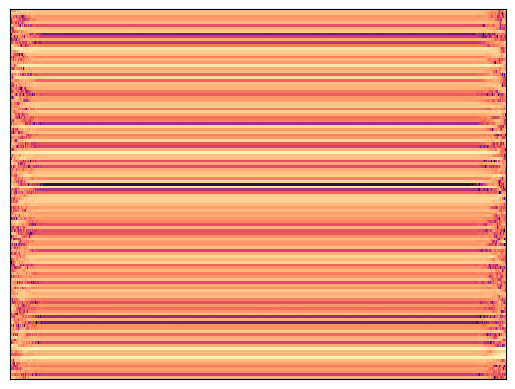

In [ ]:
S_db = librosa.amplitude_to_db(np.abs(mel_test), ref=np.max)
librosa.display.specshow(S_db)



In [ ]:
import soundfile as sf
inv_mel_spectrogram = librosa.feature.inverse.mel_to_audio(S_db)

sf.write('stereo_file1.wav', inv_mel_spectrogram, 12000, 'PCM_24')

In [ ]:
file_list = []
for i in os.listdir('wav_folder'):
  file_list.append(i)

file_path = os.path.join('wav_folder', file_list[0])
frequency, data = wavfile.read(file_path)
ipd.Audio(data, rate=frequency)